In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path


def load_lidar_bin(bin_path, min_distance=2, max_distance=30.0):
    bin_path = Path(bin_path)
    
    if not bin_path.exists():
        print("no valid path")
        return None
    
    with open(bin_path, 'rb') as f:
        data = f.read()
    
    file_size = len(data)
    
    if file_size % 16 == 0:
        points = np.frombuffer(data, dtype=np.float32).reshape(-1, 4)
        xyz = points[:, :3]
    elif file_size % 12 == 0:
        points = np.frombuffer(data, dtype=np.float32).reshape(-1, 3)
        xyz = points[:, :3]
    elif file_size % 20 == 0:
        points = np.frombuffer(data, dtype=np.float32).reshape(-1, 5)
        xyz = points[:, :3]
    else:
        points = np.frombuffer(data, dtype=np.float32)
        num_points = len(points) // 3
        xyz = points[:num_points*3].reshape(-1, 3)
    
    points_m = xyz / 100.0
    
    transformed = np.zeros_like(points_m)
    transformed[:, 0] = -points_m[:, 1]
    transformed[:, 1] = points_m[:, 0]
    transformed[:, 2] = points_m[:, 2]
    
    distances = np.sqrt(transformed[:, 0]**2 + transformed[:, 1]**2)
    valid_points = transformed[(distances >= min_distance) & (distances <= max_distance)]
    
    return valid_points

In [3]:
bin_path = "/home/nahyeon/navi/AgriChrono/data/fargo/test300/20251105_1623/LiDAR/pointcloud_sync.bin"

pcs = load_lidar_bin(bin_path, min_distance=2, max_distance=30.0)
pcs.shape

/tmp/ipykernel_8922/2781915684.py:38: RuntimeWarning: overflow encountered in square
  distances = np.sqrt(transformed[:, 0]**2 + transformed[:, 1]**2)


(51630469, 3)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path


class MapVisualizer:
    def __init__(self, vis_dir, pixels_per_meter=20):
        self.vis_dir = Path(vis_dir)
        self.vis_dir.mkdir(parents=True, exist_ok=True)
        self.pixels_per_meter = pixels_per_meter
    
    def render_occupancy_map(self, global_map, robot_pos):
        if len(global_map) == 0:
            img = np.ones((400, 400, 3), dtype=np.uint8) * 30
            return img, 200, 200, 0, 0, 400, 400
        
        world_xs = [k[0] for k in global_map.keys()]
        world_ys = [k[1] for k in global_map.keys()]
        
        min_x, max_x = min(world_xs), max(world_xs)
        min_y, max_y = min(world_ys), max(world_ys)
        
        min_x = min(min_x, robot_pos[0])
        max_x = max(max_x, robot_pos[0])
        min_y = min(min_y, robot_pos[1])
        max_y = max(max_y, robot_pos[1])
        
        margin = 5.0
        min_x -= margin
        min_y -= margin
        max_x += margin
        max_y += margin
        
        range_x = max_x - min_x
        range_y = max_y - min_y
        
        map_width = int(range_x * self.pixels_per_meter) + 1
        map_height = int(range_y * self.pixels_per_meter) + 1
        
        occupancy = np.ones((map_height, map_width, 3), dtype=np.uint8) * 30
        
        for (wx, wy), value in global_map.items():
            px = int((wx - min_x) * self.pixels_per_meter)
            py = int((wy - min_y) * self.pixels_per_meter)
            if 0 <= px < map_width and 0 <= py < map_height:
                if value == 0:
                    occupancy[py, px] = [255, 255, 255]
                else:
                    occupancy[py, px] = [0, 0, 255]
        
        robot_px = int((robot_pos[0] - min_x) * self.pixels_per_meter)
        robot_py = int((robot_pos[1] - min_y) * self.pixels_per_meter)
        
        return occupancy, robot_px, robot_py, min_x, min_y, map_width, map_height
    
    def visualize(self, frame_id, global_map, robot_pos, robot_trajectory):
        occupancy, robot_x, robot_y, min_x, min_y, map_w, map_h = self.render_occupancy_map(global_map, robot_pos)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        # RGB 이미지 부분을 0으로 채운 매트릭스로 대체
        rgb_placeholder = np.zeros((480, 640, 3), dtype=np.uint8)
        axes[0].imshow(rgb_placeholder)
        axes[0].set_title(f"Frame: {frame_id}", fontsize=12)
        axes[0].axis('off')
        
        map_display = occupancy.copy()
        
        if 0 <= robot_x < map_w and 0 <= robot_y < map_h:
            cv2.circle(map_display, (robot_x, robot_y), 8, (0, 255, 0), -1)
            cv2.circle(map_display, (robot_x, robot_y), 10, (255, 255, 255), 2)
        
        axes[1].imshow(cv2.cvtColor(map_display, cv2.COLOR_BGR2RGB))
        
        if len(robot_trajectory) > 1:
            traj = np.array(robot_trajectory)
            traj_px = (traj[:, 0] - min_x) * self.pixels_per_meter
            traj_py = (traj[:, 1] - min_y) * self.pixels_per_meter
            axes[1].plot(traj_px, traj_py, 'b-', linewidth=2, alpha=0.7, label='Trajectory')
        
        if 0 <= robot_x < map_w and 0 <= robot_y < map_h:
            axes[1].plot(robot_x, robot_y, 'g*', markersize=20, label='Robot', 
                        markeredgecolor='white', markeredgewidth=1.5)
        
        axes[1].invert_yaxis()
        axes[1].set_title(f'Occupancy Map (White: Ground, Red: Obstacle, Dark: Unknown)', fontsize=12)
        axes[1].set_xlabel('X (pixels)')
        axes[1].set_ylabel('Y (pixels)')
        axes[1].legend(loc='upper right')
        axes[1].grid(True, alpha=0.3)
        
        world_width = map_w / self.pixels_per_meter
        world_height = map_h / self.pixels_per_meter
        axes[1].text(0.02, 0.98, f'Map size: {world_width:.1f}m × {world_height:.1f}m\n'
                                  f'Robot: ({robot_pos[0]:.2f}, {robot_pos[1]:.2f})m',
                    transform=axes[1].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        
        output_path = self.vis_dir / f"frame{int(frame_id):04d}.png"
        plt.savefig(output_path, dpi=100, bbox_inches='tight')
        plt.close()
        
        print(f"Saved: {output_path}")
        return map_display


def load_lidar_from_bin(bin_path, min_distance=2, max_distance=30.0):
    """LiDAR .bin 파일 로드"""
    bin_path = Path(bin_path)
    
    if not bin_path.exists():
        return None
    
    with open(bin_path, 'rb') as f:
        data = f.read()
    
    file_size = len(data)
    
    if file_size % 16 == 0:
        points = np.frombuffer(data, dtype=np.float32).reshape(-1, 4)
        xyz = points[:, :3]
    elif file_size % 12 == 0:
        points = np.frombuffer(data, dtype=np.float32).reshape(-1, 3)
        xyz = points[:, :3]
    elif file_size % 20 == 0:
        points = np.frombuffer(data, dtype=np.float32).reshape(-1, 5)
        xyz = points[:, :3]
    else:
        points = np.frombuffer(data, dtype=np.float32)
        num_points = len(points) // 3
        xyz = points[:num_points*3].reshape(-1, 3)
    
    points_m = xyz / 100.0
    
    transformed = np.zeros_like(points_m)
    transformed[:, 0] = -points_m[:, 1]
    transformed[:, 1] = points_m[:, 0]
    transformed[:, 2] = points_m[:, 2]
    
    distances = np.sqrt(transformed[:, 0]**2 + transformed[:, 1]**2)
    valid_points = transformed[(distances >= min_distance) & (distances <= max_distance)]
    
    return valid_points


def random_sample_points(points, num_samples=30000):
    """포인트 클라우드에서 랜덤 샘플링"""
    if len(points) <= num_samples:
        return points
    
    indices = np.random.choice(len(points), num_samples, replace=False)
    return points[indices]


def points_to_ground_occupancy(points, height_threshold=0.5):
    """포인트를 ground/obstacle로 분류하여 occupancy map 생성"""
    if len(points) == 0:
        return {}
    
    ground_points = points[points[:, 2] < height_threshold]
    obstacle_points = points[points[:, 2] >= height_threshold]
    
    occupancy = {}
    
    # Ground points (흰색)
    for p in ground_points:
        gx = round(p[0], 2)
        gy = round(p[1], 2)
        key = (gx, gy)
        occupancy[key] = 0
    
    # Obstacle points (빨간색) - ground보다 우선
    for p in obstacle_points:
        gx = round(p[0], 2)
        gy = round(p[1], 2)
        key = (gx, gy)
        occupancy[key] = 1
    
    return occupancy


# 사용 예시
if __name__ == "__main__":
    # LiDAR 데이터 로드
    bin_path = "/home/nahyeon/navi/AgriChrono/data/fargo/test300/20251105_1623/LiDAR/pointcloud_sync.bin"
    
    print("Loading LiDAR data...")
    pcs = load_lidar_from_bin(bin_path, min_distance=2, max_distance=30.0)
    
    if pcs is not None:
        print(f"Total points loaded: {len(pcs):,}")
        
        print("Random sampling 30,000 points...")
        sampled_pcs = random_sample_points(pcs, num_samples=30000)
        print(f"Sampled points: {len(sampled_pcs):,}")
        
        print("Creating occupancy map...")
        global_map = points_to_ground_occupancy(sampled_pcs, height_threshold=0.5)
        print(f"Map cells: {len(global_map):,}")
        
        robot_pos = np.array([0.0, 0.0])
        robot_trajectory = [np.array([0.0, 0.0])]
        
        # Visualizer 초기화 및 맵 그리기
        print("Visualizing map...")
        visualizer = MapVisualizer(vis_dir="./visualization", pixels_per_meter=20)
        visualizer.visualize(
            frame_id=0,
            global_map=global_map,
            robot_pos=robot_pos,
            robot_trajectory=robot_trajectory
        )
        
        print("\nDone!")
        print(f"Ground points: {sum(1 for v in global_map.values() if v == 0):,}")
        print(f"Obstacle points: {sum(1 for v in global_map.values() if v == 1):,}")

Loading LiDAR data...


/tmp/ipykernel_8922/3351724675.py:143: RuntimeWarning: overflow encountered in square
  distances = np.sqrt(transformed[:, 0]**2 + transformed[:, 1]**2)


Total points loaded: 51,630,469
Random sampling 30,000 points...
Sampled points: 30,000
Creating occupancy map...
Map cells: 22,066
Visualizing map...
Saved: visualization/frame0000.png

Done!
Ground points: 7,296
Obstacle points: 14,770


In [2]:
import open3d as o3d
import numpy as np

def bin_to_ply(bin_file, ply_file):
    
    points = np.fromfile(bin_file, dtype=np.float32)
    points = points[3:].reshape(-1, 4)
    
    transformed = np.zeros_like(points)
    transformed[:, 0] = -points[:, 1]
    transformed[:, 1] = points[:, 0]
    transformed[:, 2] = points[:, 2]
    # PointCloud 객체 생성
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(transformed[:, :3])  # x, y, z만
    
    
    o3d.io.write_point_cloud(ply_file, pcd)
    print(f"Converted {bin_file} -> {ply_file}")
    print(f"Points: {len(pcd.points)}")

# 사용 예시
bin_to_ply("/home/nahyeon/navi/AgriChrono/data/fargo/1110/20251110_1720/LiDAR/pointcloud_sync.bin", "./output.ply")

FileNotFoundError: [Errno 2] No such file or directory: '/home/nahyeon/navi/AgriChrono/data/fargo/1110/20251110_1720/LiDAR/pointcloud_sync.bin'

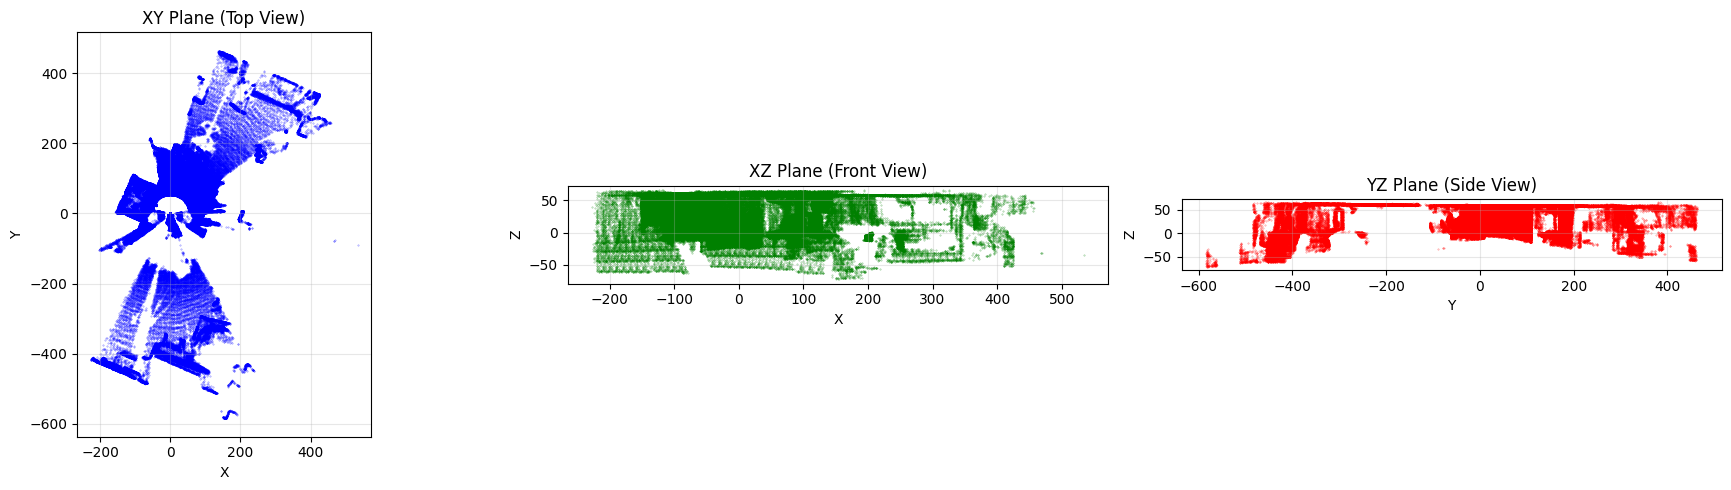

In [6]:
import matplotlib.pyplot as plt 


bin_file = "/home/nahyeon/navi/AgriChrono/data/fargo/1110/20251111_1252/LiDAR/pointcloud_sync.bin"
points = np.fromfile(bin_file, dtype=np.float32)

points = points[3:].reshape(-1, 4)

transformed = np.zeros_like(points)
transformed[:, 0] = -points[:, 1]
transformed[:, 1] = points[:, 0]
transformed[:, 2] = points[:, 2]

points = transformed

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# XY plane (top view - Z projection)
axes[0].scatter(points[:, 0], points[:, 1], s=0.1, c='blue', alpha=0.5)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('XY Plane (Top View)')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# XZ plane (front view - Y projection)
axes[1].scatter(points[:, 0], points[:, 2], s=0.1, c='green', alpha=0.5)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')
axes[1].set_title('XZ Plane (Front View)')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# YZ plane (side view - X projection)
axes[2].scatter(points[:, 1], points[:, 2], s=0.1, c='red', alpha=0.5)
axes[2].set_xlabel('Y')
axes[2].set_ylabel('Z')
axes[2].set_title('YZ Plane (Side View)')
axes[2].set_aspect('equal')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


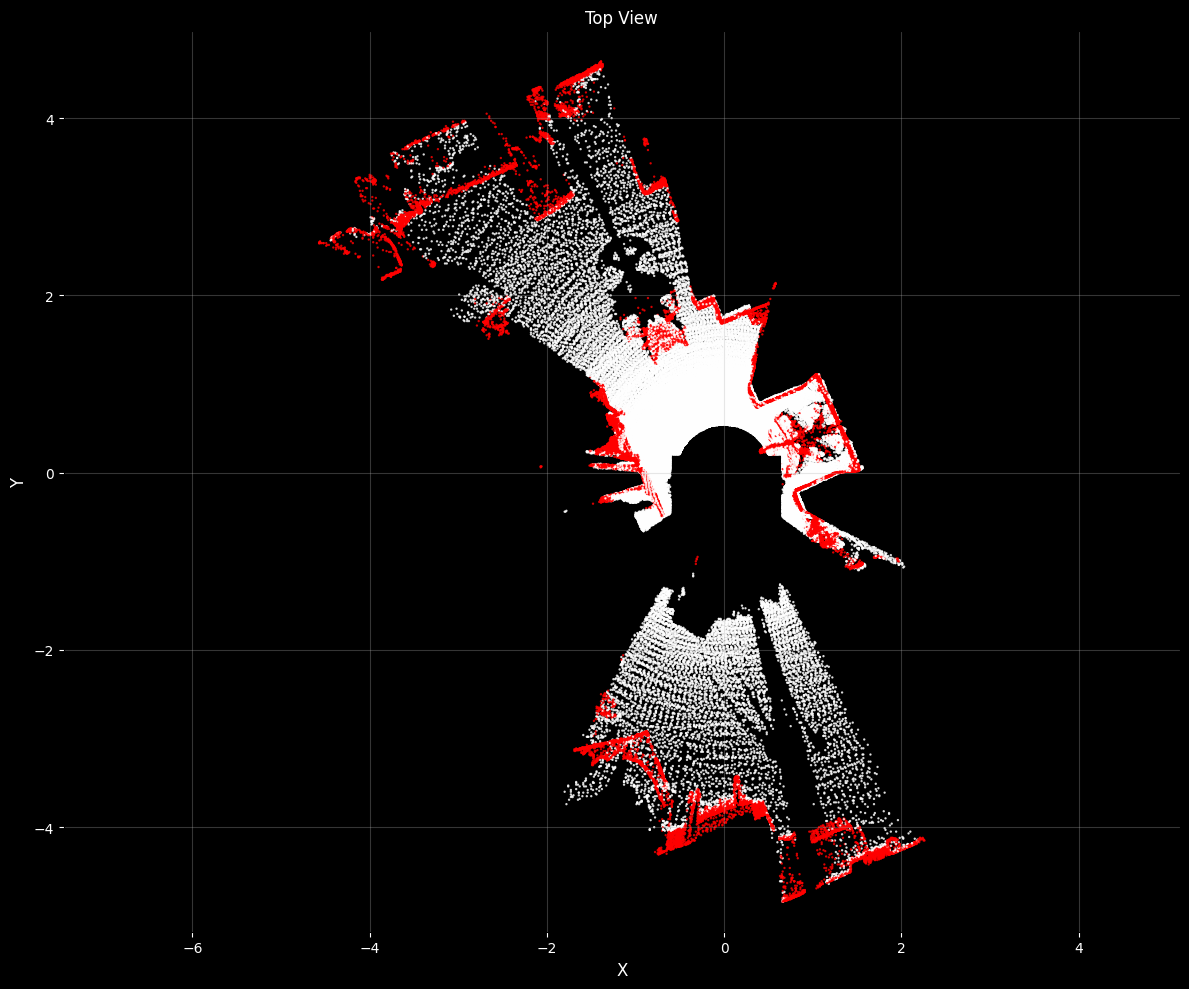

In [7]:

bin_file = "/home/nahyeon/navi/AgriChrono/data/fargo/1110/20251111_1252/LiDAR/pointcloud_sync.bin"
points = np.fromfile(bin_file, dtype=np.float32)

points = points[3:].reshape(-1, 4)/ 100.0

transformed = np.zeros_like(points)
transformed[:, 0] = points[:, 1]
transformed[:, 1] = points[:, 0]
transformed[:, 2] = -points[:, 2]
transformed = transformed[transformed[:,2] < 0]
mask = ~((transformed[:, 1] >= -0.8) & (transformed[:, 1] <= 0.2) & 
         (transformed[:, 0] >= -0.6) & (transformed[:, 0] <= 0.65))
transformed = transformed[mask]

colors = np.zeros((len(transformed), 3))  # RGB
th = -0.55
mask1 = transformed[:, 2] < th
colors[mask1] = [1, 1, 1]

mask2 = transformed[:, 2] >= th
colors[mask2] = [1, 0, 0]

plt.figure(figsize=(12, 10), facecolor='black')
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

ax = plt.gca()
ax.set_facecolor('black')

plt.scatter(transformed[:, 0], transformed[:, 1], 
            c=colors, s=0.5, alpha=0.8)

plt.xlabel('X', fontsize=12, color="white")
plt.ylabel('Y', fontsize=12, color="white")
plt.title('Top View')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:

bin_file = "/home/nahyeon/navi/AgriChrono/data/fargo/1110/20251110_1720/LiDAR/pointcloud_sync.bin"
points = np.fromfile(bin_file, dtype=np.float32)


In [38]:
points[:10]

array([-1.2514647e-09,  5.6038146e+00,  5.6056423e-40,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  5.0000000e+00,  5.5000000e+01,
       -1.6000000e+01,  5.9000000e+01], dtype=float32)

In [3]:

bin_file = "/home/nahyeon/navi/AgriChrono/data/fargo/1110/20251111_1252/LiDAR/pointcloud_sync.bin"
points = np.fromfile(bin_file, dtype=np.float64)
points[:10]


array([1.35922790e+02, 7.14682558e+12, 6.44245200e+09, 6.59707081e+12,
       4.29496835e+09, 7.69658243e+12, 4.29496836e+09, 9.89560465e+12,
       6.44245200e+09, 6.04731395e+12])

In [4]:

def load_lidar_from_bin(self, bin_path, min_distance=0.1, max_distance=30.0):
    
    for _ in range(3):
        
        if not os.path.exists(bin_path):
            time.sleep(1)
            continue
        
        points = np.fromfile(bin_path, dtype=np.float32)
        points = points[3:].reshape(-1, 4)/ 100.0
        
        transformed = np.zeros_like(points)
        transformed[:, 0] = points[:, 1]
        transformed[:, 1] = points[:, 0]
        transformed[:, 2] = -points[:, 2]
        transformed[:, 3] = points[:, 3]
        transformed = transformed[transformed[:,2] < 0]
        mask = ~((transformed[:, 1] >= -0.8) & (transformed[:, 1] <= 0.2) & 
                (transformed[:, 0] >= -0.6) & (transformed[:, 0] <= 0.65))
        transformed = transformed[mask]
        print(transformed.shape)
        
        sampled_points = random_sample_points(transformed, self.sample_points_num)
        sampled_points = np.array(sampled_points, dtype=np.float64)
        print(sampled_points.shape)
        
        return sampled_points
    
    if not os.path.exists(bin_path):
        print(f"{bin_path} not exists.")
        exit()
        